In [1]:
import pandas as pd
import nltk
df = pd.read_csv('clean_data1.csv')
df = df.drop(['Resume'],axis=1)
df.rename(columns={'newer_res':'Resume'},inplace=True)
resume_punc = df["Resume"].copy(deep  = True)
df.head()

,Unnamed: 0,ID,Category,Resume
0,0,1,HR,"john h. smith , p.h.r . 800-991-5187 | po box ..."
1,1,2,HR,name surname address mobile no/email personal ...
2,2,3,HR,anthony brown hr assistant areas of expertise ...
3,3,4,HR,www.downloadmela.com satheesh email id : caree...
4,4,5,HR,human resources director expert organizational...


In [2]:
import string
def rem_punc(s):
    punc = string.punctuation
    return [i for i in s if i not in punc]

In [3]:
#Remove punctaution for further processing
for ind,i in enumerate(df.itertuples()):
    token = nltk.word_tokenize(i[4])
    #print(token)
    df["Resume"][ind] = " ".join(rem_punc(token))

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
import string
from wordcloud import STOPWORDS
def rem_punc(s):
    punc = string.punctuation
    return [i for i in s if i not in punc]

def rem_sw(s):
    sw = set(STOPWORDS)
    return [i for i in s if i not in sw]

def preprocess(eval_res):
    try:
        eval_res = eval(eval_res).decode()
    except:
        pass
    eval_res = eval_res.encode("ASCII","ignore").decode()
    length = len(eval_res)
    eval_res = " ".join(eval_res.split("\n"))
    token = rem_sw(nltk.word_tokenize(eval_res)) #Removing punctaution later since we need punctaution for sentence tokenization
    eval_res = " ".join(token).lower()
    return eval_res

In [5]:
from io import StringIO
col = ['Category', 'Resume']
df = df[col]
df = df[pd.notnull(df['Resume'])]
df.columns = ['Category', 'Resume']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

df.head()

,Category,Resume,category_id
0,HR,john h. smith p.h.r 800-991-5187 po box 1673 c...,0
1,HR,name surname address mobile no/email personal ...,0
2,HR,anthony brown hr assistant areas of expertise ...,0
3,HR,www.downloadmela.com satheesh email id career ...,0
4,HR,human resources director expert organizational...,0


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Resume).toarray()
labels = df.category_id
features.shape

(1199, 22086)

In [7]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    #print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3] 
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n\t. {}".format('\n\t. '.join(bigrams[-N:])))
    print("\n\n")
    #print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'Accountant':
  . Most correlated unigrams:
	. chartered
	. accountant
  . Most correlated bigrams:
	. chartered accountant
	. accountant resume



# 'Advocate':
  . Most correlated unigrams:
	. legal
	. law
  . Most correlated bigrams:
	. legal research
	. law school



# 'Agricultural':
  . Most correlated unigrams:
	. agriculture
	. horticulture
  . Most correlated bigrams:
	. pest control
	. achievement american



# 'Apparel':
  . Most correlated unigrams:
	. textiles
	. fashion
  . Most correlated bigrams:
	. fashion designer
	. space planning



# 'Architects':
  . Most correlated unigrams:
	. revit
	. drawings
  . Most correlated bigrams:
	. prepare drawings
	. auto cad



# 'Arts':
  . Most correlated unigrams:
	. artist
	. theatre
  . Most correlated bigrams:
	. make artist
	. special skills



# 'Automobile':
  . Most correlated unigrams:
	. automobile
	. automotive
  . Most correlated bigrams:
	. experience automotive
	. history 2007



# 'Aviation':
  . Most correlated u

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(df['Resume'], df['Category'], random_state = 0)

#print(x_train)

count_vect = CountVectorizer() # bag-of-ngrams model , based on frequency count
x_train_counts = count_vect.fit_transform(x_train)

tfidf_transformer = TfidfTransformer() #passing the word:word count
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

classifier = MultinomialNB().fit(x_train_tfidf, y_train)

In [16]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convertPDFtoText(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    fp.close()
    device.close()
    string = retstr.getvalue()
    retstr.close()
    return string

In [18]:
test_resume = convertPDFtoText("Latest_Resume.pdf")
print(test_resume)

Saioni Chatterjee

Adaptable, eﬃcient and dedicated individual with a spark
to excel in the modern IT industry utilizing my technical
expertise and problem-solving skills. Innovative team
player and eﬀective leader with comprehensible
communication skills. Thrives in faced-paced goal oriented
environments.

EDUCATION

B.Tech, Computer Science & Engineering
PES University, Bangalore
2017 – 2021

CGPA (Upto 5th Semester): 8.58

12th
Fiitjee Junior College, Vishakhapatnam
2017

PERCENTAGE: 97.7%

10th
De Paul School (ICSE), Vishakhapatnam
2015

PERCENTAGE: 94.2%

WORK EXPERIENCE

Data Science Technical Reviewer
Ureka Education Group
07/2020 – Present
Achievements/Tasks

Research on datasets from various domains and create interesting,
meaningful tasks for the trainees.
Suggest technical improvements and feedback to trainees.

Data Science Intern
Ureka Education Group
06/2020 – 07/2020
Achievements/Tasks

Exploratory Data Analysis, Binary Classiﬁcation
Multiclass classiﬁcation and building

In [19]:
from nltk.probability import FreqDist
from string import punctuation
import math
def summarize(doc,words):
    score={}
    fd = FreqDist(words)
    for i,t in enumerate(doc):
        score[i] = 0
        for j in nltk.word_tokenize(t):
            if j in fd:
                score[i]+=fd[j]
    
    r = sorted(list(score.items()),key=lambda x:x[1],reverse=True)[:math.floor(0.60*len(doc))]
    r.sort(key=lambda x:x[0])
    l = [doc[i[0]] for i in r]
    return "\n\n".join(l)

In [20]:
resume = preprocess(test_resume)#remove stop words etc
sent = nltk.sent_tokenize(test_resume)
puncu = punctuation
word_token = nltk.word_tokenize(test_resume)#tokenize preprocessed text for scoring

print(summarize(sent,test_resume))

Saioni Chatterjee

Adaptable, eﬃcient and dedicated individual with a spark
to excel in the modern IT industry utilizing my technical
expertise and problem-solving skills.

EDUCATION

B.Tech, Computer Science & Engineering
PES University, Bangalore
2017 – 2021

CGPA (Upto 5th Semester): 8.58

12th
Fiitjee Junior College, Vishakhapatnam
2017

PERCENTAGE: 97.7%

10th
De Paul School (ICSE), Vishakhapatnam
2015

PERCENTAGE: 94.2%

WORK EXPERIENCE

Data Science Technical Reviewer
Ureka Education Group
07/2020 – Present
Achievements/Tasks

Research on datasets from various domains and create interesting,
meaningful tasks for the trainees.

Data Science Intern
Ureka Education Group
06/2020 – 07/2020
Achievements/Tasks

Exploratory Data Analysis, Binary Classiﬁcation
Multiclass classiﬁcation and building deep learning model on
Twitter dataset to predict sentiment, data scraping using tweepy
(Publised on Medium)
Selected as the best intern based on performance and personality,
only intern to ge

In [21]:
print(classifier.predict(count_vect.transform([test_resume])))

['Engineering']


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

<Figure size 640x480 with 1 Axes>

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.721416
LogisticRegression        0.610481
MultinomialNB             0.435338
RandomForestClassifier    0.389474
Name: accuracy, dtype: float64

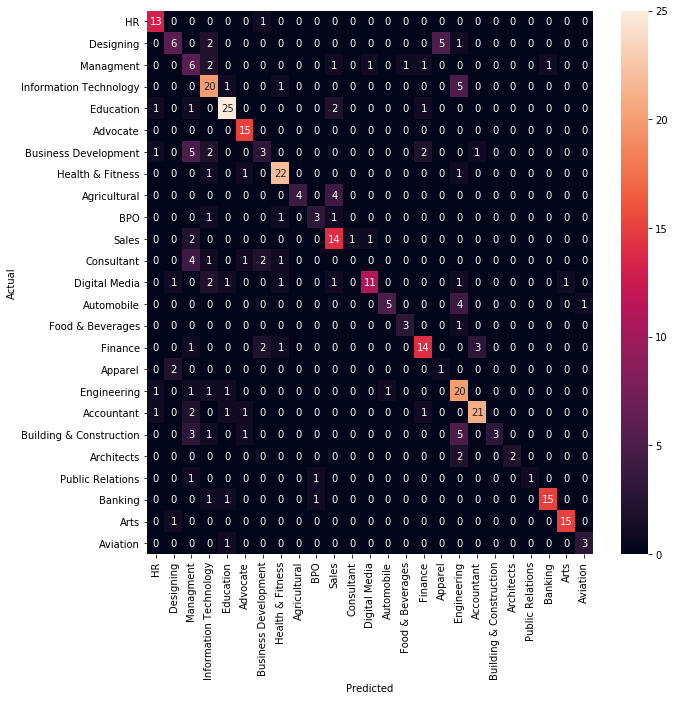

In [25]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
